**Tinkoff Lab. Лабораторная работа "Генерация жестов рук"**

*Задание 1. Идентификация спикеров*

Достаточно простая задача: классификация аудио по спикеру.

В качестве датасета предлагается использовать [VCC2018](https://datashare.is.ed.ac.uk/handle/10283/3061?show=full)

В данном датасете всего 8 спикеров: 4 мужчины и 4 женщины.
​

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython import display
import tensorflow as tf

from scipy import signal
from scipy.io import wavfile


seed = 42
np.random.seed(seed)

In [2]:
DATASET_PATH = 'train'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'vcc2018_database_training.zip',
      origin="https://datashare.ed.ac.uk/bitstream/handle/10283/3061/vcc2018_database_training.zip?sequence=2&isAllowed=y",
      extract=True,
      cache_dir='.', cache_subdir='train')

122781696/122768173 [==============================] - 308s 3us/step


In [3]:
DATASET_PATH = 'eval'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'vcc2018_database_evaluation.zip',
      origin="https://datashare.ed.ac.uk/bitstream/handle/10283/3061/vcc2018_database_evaluation.zip?sequence=3&isAllowed=y",
      extract=True,
      cache_dir='.', cache_subdir='eval')

33349632/33338426 [==============================] - 82s 2us/step


Пользоваться будем спектрограммами, поэтому посмотрим как они выглядят.

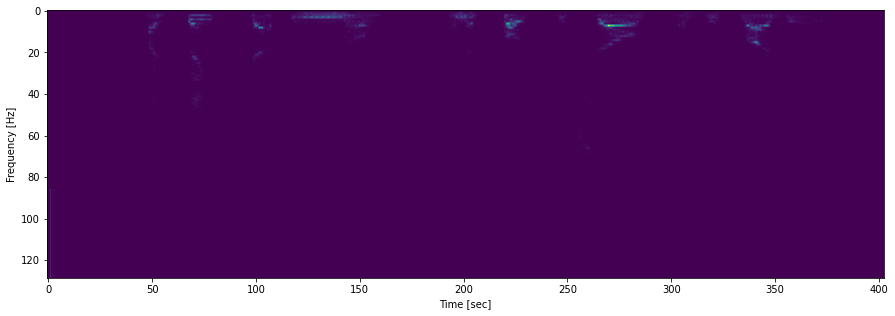

In [6]:
sample_rate, samples = wavfile.read('train/vcc2018_training/VCC2SM2/10011.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

plt.figure(figsize=(15,10))
plt.pcolormesh(times, frequencies, spectrogram)
plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
frequencies.shape, times.shape, spectrogram.shape

((129,), (403,), (129, 403))

Плохо выглядят, воспользуемся хорошим преобразованием `mfcc` из библиотеки `librosa`.

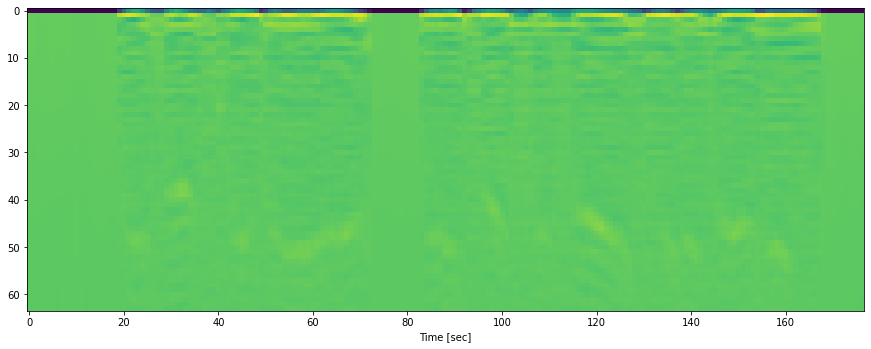

In [8]:
import librosa

y, sr = librosa.load('train/vcc2018_training/VCC2SM2/10011.wav')
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=64)
plt.figure(figsize=(15,10))
plt.imshow(mfcc)
plt.xlabel('Time [sec]')
plt.show()

Так гораздо лучше, теперь загрузим и обработаем данные. 

Записи разного размера, но если мы хотим использовать какую-нибудь классическую модель вроде линейной регрессии(*спойлер: хотим*), то нам не нужны двумерные элементы, поэтому просто усредним каждый канал по времени.

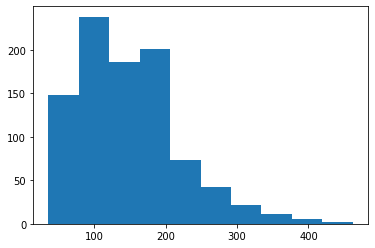

In [18]:
DIRs = {
        "VCC2SF1" : [0],
        "VCC2SF2" : [1],
        "VCC2SF3" : [2],
        "VCC2SF4" : [3],
        "VCC2SM1" : [4],
        "VCC2SM2" : [5],
        "VCC2SM3" : [6],
        "VCC2SM4" : [7],
}

with1 = ["VCC2SF1", "VCC2SF2", "VCC2SM1", "VCC2SM2"]

files = []
for i in range(81):
  files.append("00" + ("0" if i < 9 else "") + str(i+1) + ".wav")

X_test = []
X_train = []
y_test = []
y_train = []

lengths = []
for dir in DIRs.keys():
  for file in files:
    samples, sample_rate = librosa.load('/content/train/vcc2018_training/' + dir + '/' + ("1" if dir in with1 else "2") + file)
    spectrogram = librosa.feature.mfcc(samples, sample_rate, n_mfcc=64)
    X_train.append(np.array(spectrogram, dtype=np.float32).mean(axis=1))
    y_train.append(DIRs[dir][0])
    lengths.append(len(spectrogram[0]))

for dir in DIRs.keys():
  for file in files[:35]:
    samples, sample_rate = librosa.load('/content/eval/vcc2018_evaluation/' + dir + '/' + "3" + file)
    spectrogram = librosa.feature.mfcc(samples, sample_rate, n_mfcc=64)
    X_test.append(np.array(spectrogram, dtype=np.float32).mean(axis=1))
    y_test.append(DIRs[dir][0])
    lengths.append(len(spectrogram[0]))

plt.hist(lengths)
plt.show()

Перемешиваем данные

In [19]:
n1 = np.random.permutation(81 * 8)
n2 = np.random.permutation(35 * 8)

X_train = np.array(X_train)[n1]
y_train =  np.array(y_train)[n1]
X_test =  np.array(X_test)[n2]
y_test =  np.array(y_test)[n2]

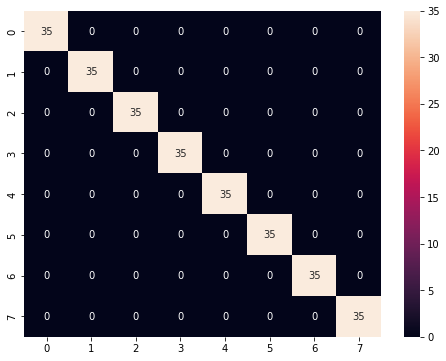

1.0


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

logreg = LogisticRegression(max_iter=1e8)
logreg.fit(X_train, y_train)
preds = logreg.predict(X_test)
cf_matrix = confusion_matrix(y_test, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True)
plt.show()
print(logreg.score(X_test, y_test))

Нет ошибок, думаю, на этом можно остановиться. Можно было бы построить свёрточную нейросеть(я даже это делала), но для этого потребовалось бы приводить данные к одной длине, что могло бы внести помехи и в конечном итоге привести к результату хуже(так у меня и получалось).

**Небольшой вывод о проведённой работе**

Построен хороший классификатор даже без использования сложных моделей. Заставляет задуматься о том, что хорошее преобразование перед обучением может сделать большую часть работы, спасибо за это преобразование библиотеке `librosa`.